Architecture based on the solution proposed in https://arxiv.org/pdf/1911.00937.pdf , appendix D.1

In [1]:
pip install neptune-client;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 897.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.6 MB/s eta 0:00:00


In [2]:
pip install neptune-notebooks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00
  Created wheel for neptune-notebooks: filename=neptune_notebooks-0.9.3-py2.py3-none-any.whl size=1074609 sha256=e8f9572eac28159eac23dec6cefc8fcd12cb3e768736f578f5cd80fb2e079170
  Stored in directory: /root/.cache/pip/wheels/16/32/72/b4fb207ede5ec809fa1e250b3c931d41bbfef41068f6189e68
Successfully built neptune-notebooks


In [3]:
pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.9 MB/s eta 0:00:00


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import neptune.new as neptune
import foolbox as fb
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-ab5ad47a7f98>:6: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Cifar100Experiments/NaiveConstrained"

Mounted at /content/gdrive
/content/gdrive/My Drive/Cifar100Experiments/NaiveConstrained


In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #cifar10
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #cifar100
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #cifar10
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #cifar100
])

In [8]:
batch_size = 128

n_classes = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
#Convolutional layers
def deconv_orth_dist(kernel, padding = 2, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    output = torch.conv2d(kernel, kernel, padding=padding)
    target = torch.zeros((o_c, o_c, output.shape[-2], output.shape[-1])).cuda()
    ct = int(np.floor(output.shape[-1]/2))
    target[:,:,ct,ct] = torch.eye(o_c).cuda()
    return torch.norm( output - target )

def conv_orth_dist(kernel, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    assert (w == h),"Do not support rectangular kernel"
    assert stride<w,"Please use matrix orthgonality instead"
    new_s = stride*(w-1) + w#np.int(2*(half+np.floor(half/stride))+1)
    temp = torch.eye(new_s*new_s*i_c).reshape((new_s*new_s*i_c, i_c, new_s,new_s)).cuda()
    out = (F.conv2d(temp, kernel, stride=stride)).reshape((new_s*new_s*i_c, -1))
    Vmat = out[np.floor(new_s**2/2).astype(int)::new_s**2, :]
    temp= np.zeros((i_c, i_c*new_s**2))
    for i in range(temp.shape[0]):temp[i,np.floor(new_s**2/2).astype(int)+new_s**2*i]=1
    return torch.norm( Vmat@torch.t(out) - torch.from_numpy(temp).float().cuda() )

In [10]:
def power_method(A, A_t, u_init, k=1):
    u = u_init
    for i in range(k):
        v = A(u)
        v /= torch.sqrt(torch.sum(v**2))
        u = A_t(v)
        sigma = torch.sum(u * u)
        u /= torch.sqrt(torch.sum(u**2))
    return sigma, u[0] #so it returns a 3d tensor

def compute_spectral_norm(conv, u_init=None, im_size=(3, 32, 32), k=1,device='cuda'):
    if u_init is None:
        with torch.no_grad():
            u_init = torch.randn(1, *im_size).to(conv.weight.device)
    u_init = u_init.to(conv.weight.device)
    with torch.no_grad():
        return power_method(lambda u: torch.nn.functional.conv2d(u, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                lambda v: torch.nn.functional.conv_transpose2d(v, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                u_init, k)

In [11]:
def genOrthgonal(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.linalg.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q


In [12]:
def makeDeltaOrthogonal(weights, gain):
    rows = weights.size(0)
    cols = weights.size(1)
    if rows > cols:
        print("In_filters should not be greater than out_filters.")
    weights.data.fill_(0)
    dim = max(rows, cols)
    q = genOrthgonal(dim)
    mid1 = weights.size(2) // 2
    mid2 = weights.size(3) // 2
    weights[:, :, mid1, mid2] = q[:weights.size(0), :weights.size(1)]
    weights.mul_(gain)

In [13]:
class CNNBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size, padding, shape):
        super(CNNBlock, self).__init__()

        self.shape = shape
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size=kernel_size, padding=padding)
        self.storedEigVect = torch.rand(in_chan,shape[0], shape[1])

        #makeDeltaOrthogonal(self.conv.weight.data, nn.init.calculate_gain('leaky_relu',0))

    def reg(self,):
      return deconv_orth_dist(torch.transpose(self.conv.weight,0,1))

    def forward(self,x):
      #print(self.shape)
      #print(x.shape)
      return self.conv(x)

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    convo = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    layers = [convo]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [15]:
# From https://github.com/JiJingYu/delta_orthogonal_init_pytorch/blob/master/demo.py
def genOrthgonal(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.linalg.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q


def makeDeltaOrthogonal(weights, gain):
    rows = weights.size(0)
    cols = weights.size(1)
    if rows > cols:
        print("In_filters should not be greater than out_filters.")
    weights.data.fill_(0)
    dim = max(rows, cols)
    q = genOrthgonal(dim)
    mid1 = weights.size(2) // 2
    mid2 = weights.size(3) // 2
    weights[:, :, mid1, mid2] = q[:weights.size(0), :weights.size(1)]
    weights.mul_(gain)

In [16]:
dt = 1 # standard ResNET

class CNNBlock2(nn.Module):
    def __init__(self, in_chan, nf, n_layers):
        super(CNNBlock2, self).__init__()

        self.nlayers = n_layers
        self.nf = nf
        self.chans = in_chan

        self.matrices = self.nlayers

        self.conv1 = conv_block(self.chans, self.nf,pool=False)
        self.convs = nn.ModuleList([nn.Conv2d(self.nf, self.nf,3,1,1,bias=True) for i in range(self.matrices)])
        self.convsO = nn.ModuleList([nn.Conv2d(self.nf, self.nf,3,1,1,bias=False) for i in range(self.matrices)])

        for i in range(len(self.convs)):
          makeDeltaOrthogonal(self.convs[i].weight.data, nn.init.calculate_gain('leaky_relu',0))
          makeDeltaOrthogonal(self.convsO[i].weight.data, nn.init.calculate_gain('leaky_relu',0))

        self.mp = nn.MaxPool2d(2,2)

    def getReg(self,):
        reg = 0
        for i in range(self.nlayers):
            reg += deconv_orth_dist(self.convs[i].weight) + deconv_orth_dist(self.convsO[i].weight)
        return reg

    def forward(self, x):
        x = self.conv1(x)

        count = 0

        #cc = Positive(self.ells)

        for i in np.arange(0,self.matrices):
          A = self.convs[i]
          B = self.convsO[i]
          x = 0.5 * (x + dt * B(torch.relu(A(x))))

        x = self.mp(x)
        return x

class CNN(nn.Module):
    def __init__(self, in_chan, nf1, nf2, nf3, n_l1, n_l2, n_l3):
        super(CNN, self).__init__()

        self.input = in_chan
        self.nf1 = nf1
        self.nf2 = nf2
        self.nf3 = nf3
        self.n_l1 = n_l1
        self.n_l2 = n_l2
        self.n_l3 = n_l3

        self.seq = nn.Sequential(
            CNNBlock2(self.input,self.nf1,self.n_l1),
            CNNBlock2(self.nf1,self.nf2,self.n_l2),
            CNNBlock2(self.nf2,self.nf3,self.n_l3),
            nn.Flatten()
          )
        self.lin = nn.Linear(2048,10)
        #self.lin = nn.Linear(2048,100)
 
    def getReg(self,):
        
        return self.seq[0].getReg() + self.seq[1].getReg() + self.seq[2].getReg()

    def forward(self,x):
      x = self.seq(x)
      x = self.lin(x)
      return x

model = CNN(3,32,64,128,4,4,4)
model.to(device);

In [17]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"The network has {params} trainable parameters")

The network has 1662922 trainable parameters


In [18]:
lr = 1e-2 #cifar10
momentum = 0.9
optimizer = 'stochastic gradient descent'
scheduler = 'stepLR'
step_size = 30
EPOCHS = 100
weight_decay = 0

In [19]:
class multiClassHingeLoss(nn.Module):
    def __init__(self, p=1, margin=1, device='cpu', size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.margin=margin
        self.size_average=size_average
        self.device = device
    def forward(self, output, y):
        output_y=output[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)].view(-1,1) #it is a (Batch Size x 1) tensor, having entries that are x[y]
        loss=output-output_y+self.margin #this has self.margin in position y and the difference between the entry of x and x[y] in the other positions
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)]=0 #sets to 0 the entry in position y, instead of having self.margin
        #max(0,_)
        loss[loss<0]=0 #sets to 0 the entries of loss where we have negative numbers, i.e. those meeting the margin (there is a higher difference than the margin between x[y] and x[i])
        #sum up
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]
        return loss

In [20]:
class Normalisation(torch.nn.Module):
    #def __init__(self, means=(0.485, 0.456, 0.406), stds=(0.229, 0.224, 0.225)): #cifar100
    def __init__(self, means=(0.4914, 0.4822, 0.4465), stds=(0.2023, 0.1994, 0.2010)): #cifar10
        super().__init__()
        assert len(means) == len(stds)
        self.means = means
        self.stds = stds
    
    def forward(self, x):
        return (x - torch.tensor(self.means, device=x.device).view(1, len(self.means), 1, 1)) / torch.tensor(self.stds, device=x.device).view(1, len(self.means), 1, 1)

In [21]:
import torch.optim as optim

marginList = [0.07,0.15,0.3]
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]

robust_accuracy = np.zeros((len(marginList),len(epsilons)))

<ipython-input-22-4c4dba693010>:14: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/geometricintegrationntnu/Cifar10CNN/e/CNN10-76
Loss [1, 100](epoch, minibatch):  2.3560311889648435
Loss [1, 200](epoch, minibatch):  2.0302070021629333
Loss [1, 300](epoch, minibatch):  1.817807239294052
Norms: []
Orthogonality violation: [24.537702560424805, 42.126319885253906, 67.95391845703125]
Current accuracy on 10000 test images: 49 %
Loss [2, 100](epoch, minibatch):  1.5046754825115203
Loss [2, 200](epoch, minibatch):  1.3396096909046173
Loss [2, 300](epoch, minibatch):  1.181289712190628
Norms: []
Orthogonality violation: [8.779098510742188, 23.902469635009766, 47.96232604980469]
Current accuracy on 10000 test images: 53 %
Loss [3, 100](epoch, minibatch):  0.9459554916620254
Loss [3, 200](epoch, minibatch):  0.8137709850072861
Loss [3, 300](epoch, minibatch):  0.7124728411436081
Norms: []
Orthogonality violation: [0.3978361487388611, 9.363240242004395, 30.767126083374023]
Current accuracy on 10000 test images: 59 %
Loss [4, 100](epoch, minibatch):  0.547

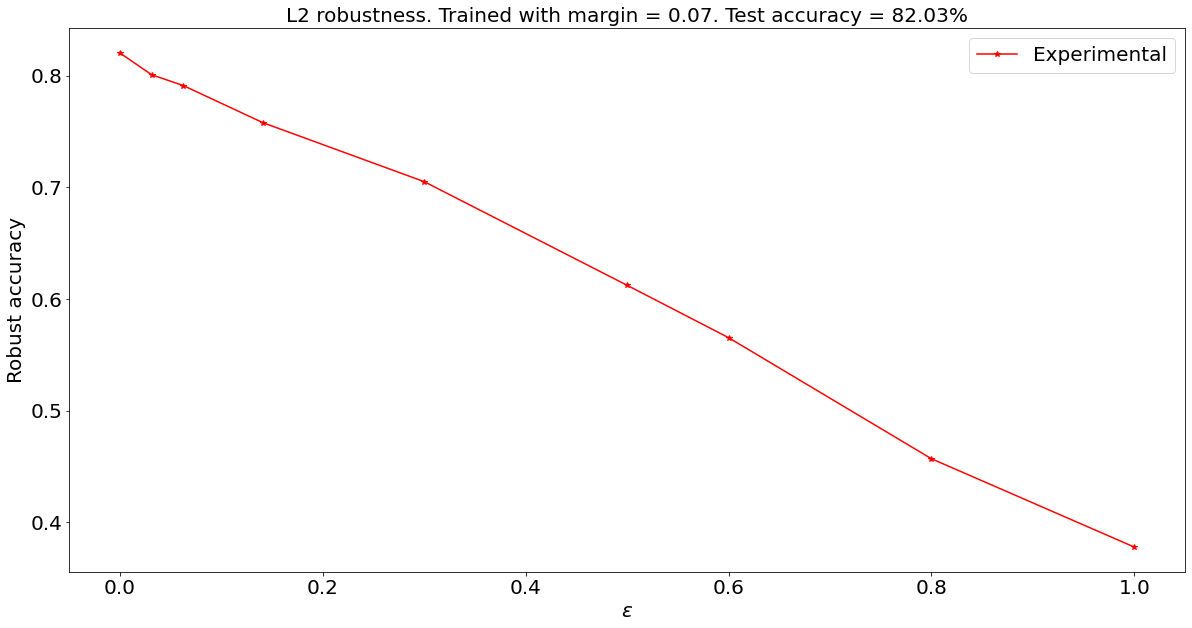

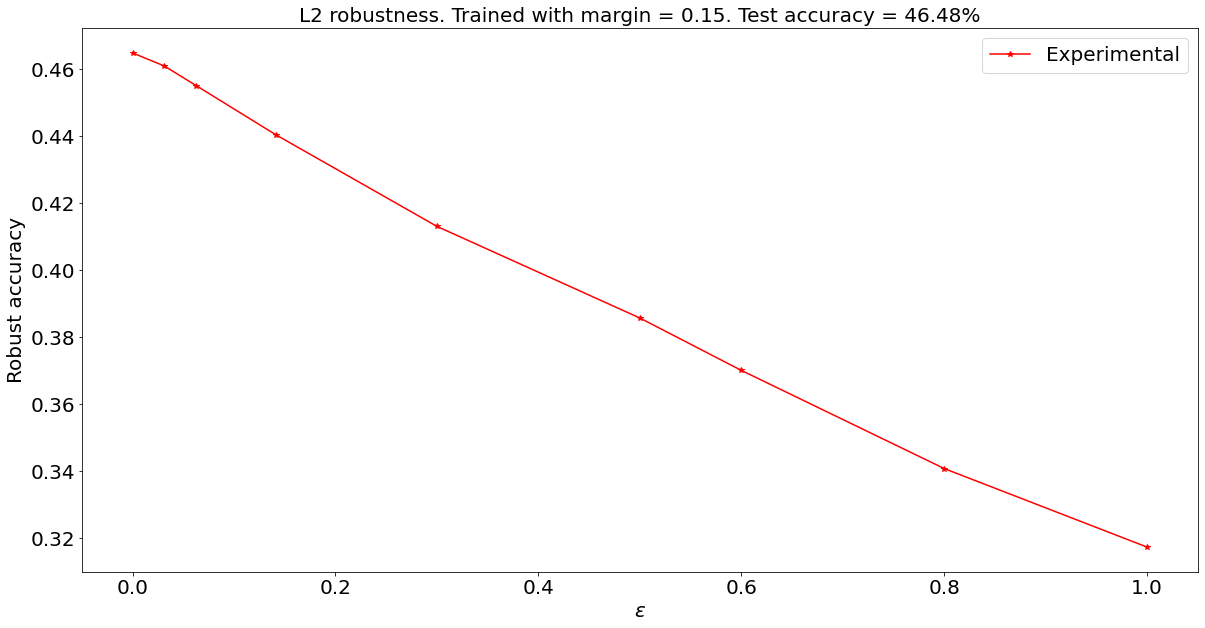

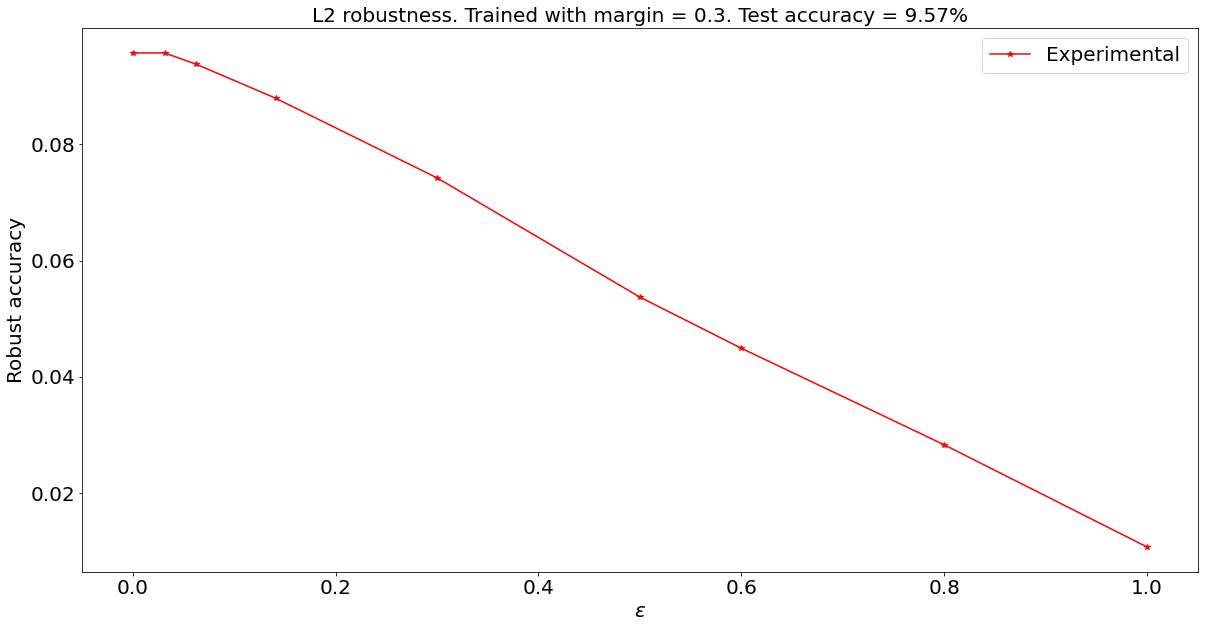

In [ ]:
for iterate,margin in enumerate(marginList):

  model = CNN(3,32,64,128,4,4,4)
  model.to(device);

  #pretrained_dict = torch.load(f"trained_model_{margin}.pt")
  #model.load_state_dict(pretrained_dict, strict=False)

  #criterion = nn.CrossEntropyLoss().to(device)
  criterion = multiClassHingeLoss(margin = margin)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

  run = neptune.init_run(
    project="geometricintegrationntnu/Cifar10CNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2YzM5YjI2My1kYTI2LTRhNmMtOWI5Ni1lYzlmYzBiZWZiNzIifQ==",
  )
  '''run = neptune.init_run(
    project="geometricintegrationntnu/Cifar100CNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2YzM5YjI2My1kYTI2LTRhNmMtOWI5Ni1lYzlmYzBiZWZiNzIifQ==",
)  # your credentials'''
  
  gamma = .01

  config = {
    "learning_rate":lr, 
    "epochs":EPOCHS, 
    "batch_size":batch_size, 
    "weight_decay":weight_decay,
    "optimizer":"sgd method",
    "gamma":gamma
    }
  run["parameters"] = config


  EPOCHS = 100
  for epoch in range(EPOCHS):
      losses = []
      running_loss = 0
      correct = 0
      count = 0
      for i, inp in enumerate(trainloader):
          inputs, labels = inp
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
      
          outputs = model(inputs)
          l1_reg = gamma * model.getReg()
          loss = criterion(outputs, labels)+l1_reg
          losses.append(loss.item())
          loss.backward()

          optimizer.step()
          running_loss += loss.item()

          '''with torch.no_grad():
            #model.lin.weight.data /= max(1,torch.norm(model.lin.weight.data,2)/1)
            _, predicted = torch.max(outputs.data, 1)
            count += 1
            correct += (predicted == labels.to(device)).sum().item() / len(inputs) #percentage of correct ones'''
          if i%100 == 0 and i > 0:
              print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
              running_loss = 0.0
      
      #run["train/accuracy"].log(correct/count)
      #run["train/loss"].log(loss.item())

      #Check current accuracy
      correct = 0
      total = 0
      # since we're not training, we don't need to calculate the gradients for our outputs
      
      model.eval()
      with torch.no_grad():
          
          norms = []
          regTerms = []
          for k in range(3):
            #n, _ = lp,model.convs[k].storedEigVect = compute_spectral_norm(model.convs[k].conv, model.convs[k].storedEigVect.unsqueeze(0), model.convs[k].shape)
            #norms.append(n.item())
            regTerms.append(model.seq[k].getReg().item())
            
          print(f"Norms: {norms}")
          print(f"Orthogonality violation: {regTerms}")


          for data in testloader:
              images, labels = data
              images.shape
              # calculate outputs by running images through the network
              outputs = model(images.to(device))
              # the class with the highest energy is what we choose as prediction
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels.to(device)).sum().item()
          print('Current accuracy on 10000 test images: %d %%' % (
              100 * correct / total))
          #print(net.seq[1].u.data)
      run["test/accuracy"].log(correct / total)
      model.train()
      scheduler.step()
      if epoch%10 == 0 and epoch>0:
          lr=optimizer.param_groups[0]["lr"]
  print('Training Done')

  model.eval();
  transform_test_rob = transforms.Compose([
    transforms.ToTensor()
  ])
  batch_size = 1024
  #testset_rob = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        #download=True, transform=transform_test_rob)
  testset_rob = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test_rob)
  testloader_rob = torch.utils.data.DataLoader(testset_rob, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  images, labels = next(iter(testloader_rob))
  images, labels = images.to(device), labels.to(device)
  model = nn.Sequential(Normalisation(),model).eval()
  fmodel = fb.PyTorchModel(model, bounds=(0, 1))
  
  acc = fb.utils.accuracy(fmodel, images, labels)
  attack = fb.attacks.L2PGD(steps=10)
  
  _, advs, success = attack(fmodel, images, labels, epsilons=epsilons)
  robust_accuracy[iterate] = torch.mean((1-1.*success),axis=1).detach().cpu().numpy()

  fig = plt.figure(figsize=(20,10))
  plt.plot(epsilons,robust_accuracy[iterate],'r-*',label="Experimental")
  plt.xlabel(r"$\varepsilon$",fontsize=20)
  plt.ylabel("Robust accuracy",fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.legend(fontsize=20,loc=1)
  plt.title(f"L2 robustness. Trained with margin = {margin}. Test accuracy = {round(acc * 100,2)}%",fontsize=20);

  #plt.savefig(f'Cifar100_L2margin_{margin}.png')
  plt.savefig(f'Cifar10_L2margin_{margin}.png')

  dataForTxt = robust_accuracy[iterate]
  #destination = f"Cifar100_updateMargin_{margin}.txt"
  destination = f"Cifar10_updateMargin_{margin}.txt"
  np.savetxt(destination, dataForTxt.reshape(-1,1))

  torch.save(model.state_dict(), f"trained_model_margin_{margin}.pt")
  print("Waiting 2 minutes to make sure to save the right files")
  time.sleep(120) # Delay for 1 minute (60 seconds).
  run["trained_model"].upload(f"trained_model_margin_{margin}.pt")
  run["txtFileRobustness"].upload(destination)
  #run[f"L2Margin{margin}"].upload(f'Cifar100_L2margin_{margin}.png')
  run[f"L2Margin{margin}"].upload(f'Cifar10_L2margin_{margin}.png')

  run.stop()

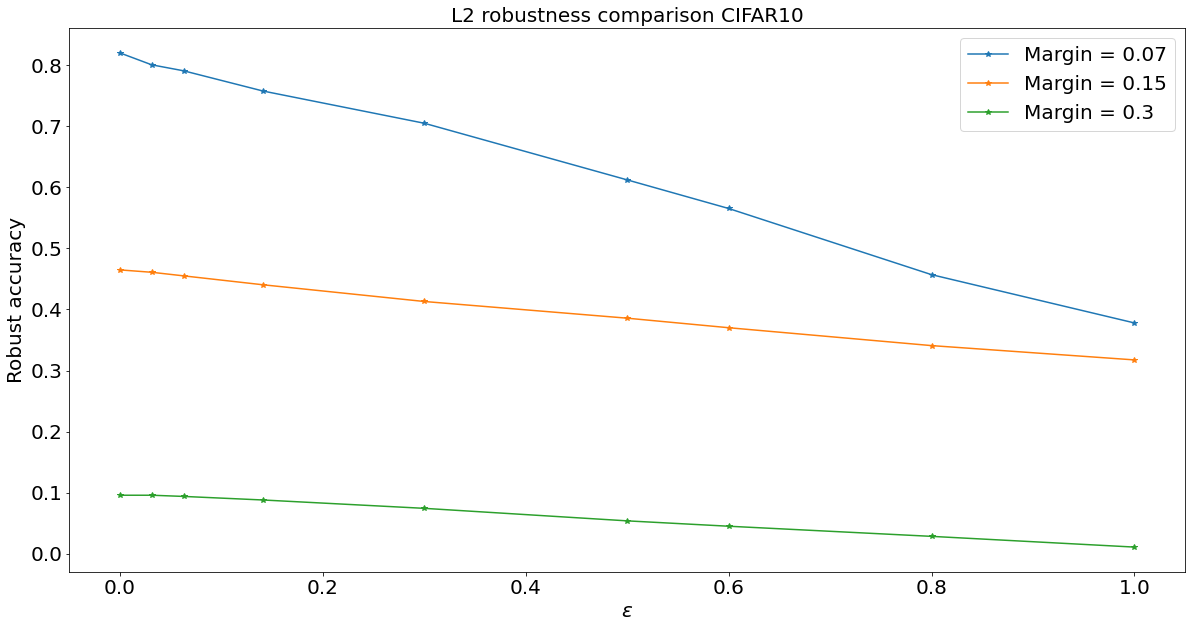

In [ ]:
marginList = [0.07, 0.15,0.3]
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]
fig = plt.figure(figsize=(20,10))
for i in range(len(marginList)):
  plt.plot(epsilons,robust_accuracy[i],'-*',label=f"Margin = {marginList[i]}")
plt.xlabel(r"$\varepsilon$",fontsize=20)
plt.ylabel("Robust accuracy",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc=1)
plt.title(f"L2 robustness comparison CIFAR10",fontsize=20);
plt.savefig("Cifar10_RobustnessCNN.png")
plt.show()